In [89]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [90]:
train = pd.read_excel("./res/result4.xlsx")

In [91]:
train['CustomerId'].nunique()

9180

In [92]:
train.head()

,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Status,AssetStage,IsActiveStatus,IsActiveAssetStage,CrCardAssetStage
0,15553251,713,1,52,0,185891.54,1,1,1,46369.57,1,新客户,高资产,3,9,9
1,15553256,619,1,41,8,0.00,3,1,1,79866.73,1,老客户,低资产,5,6,6
2,15553283,603,1,42,8,91611.12,1,0,0,144675.30,1,老客户,中上资产,2,2,5
3,15553308,589,1,61,1,0.00,1,1,0,61108.56,1,新客户,低资产,0,0,6
4,15553387,687,1,39,2,0.00,3,0,0,188150.60,1,新客户,低资产,0,0,0


In [93]:
for i in ['Status','AssetStage']:
    lb = LabelEncoder()
    train[i] = lb.fit_transform(train[i])

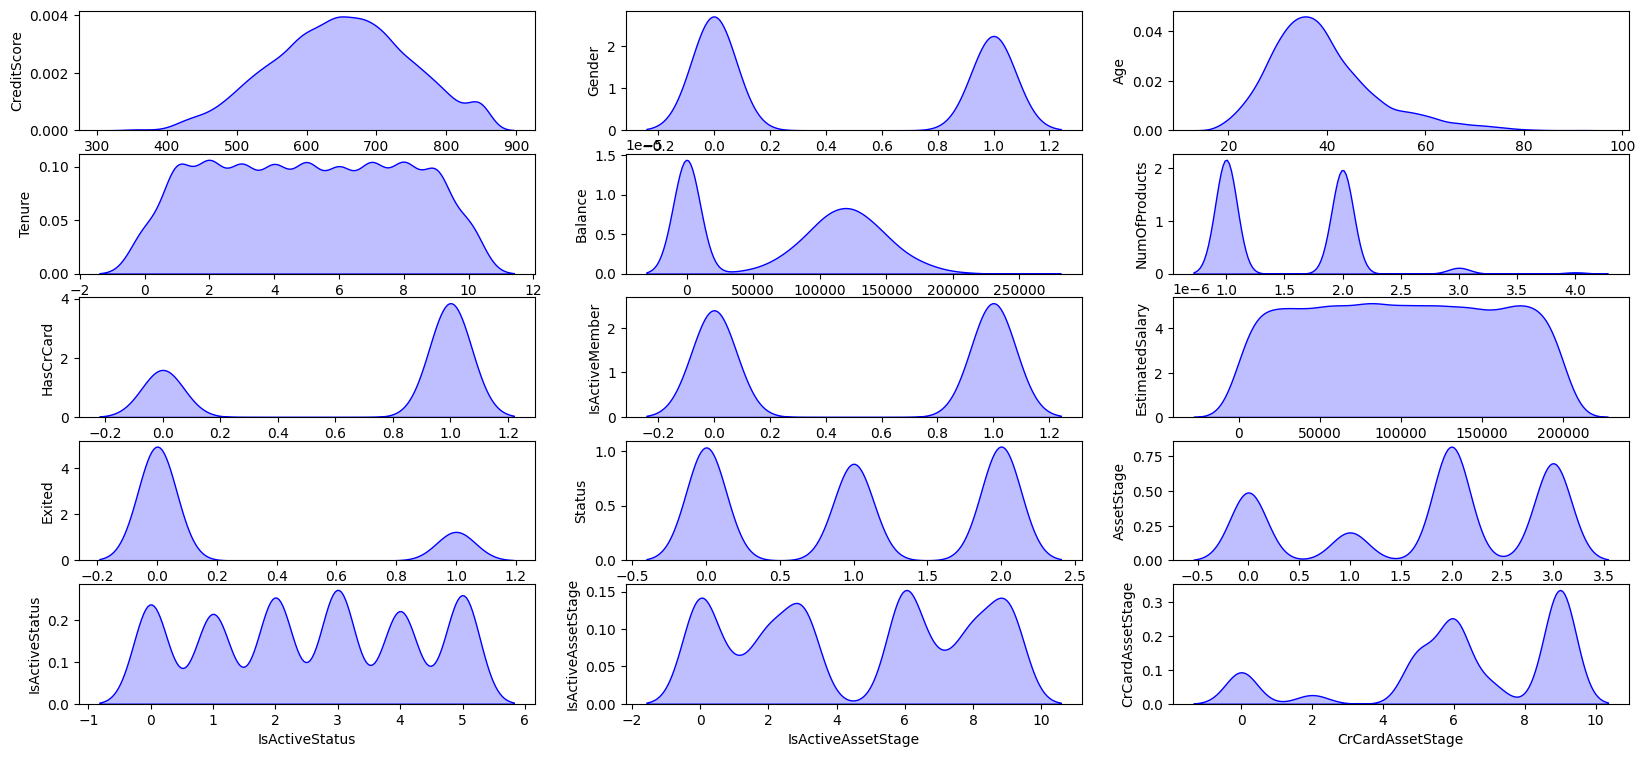

In [94]:
feats = [i for i in train.columns.tolist() if i not in ['CustomerId']]
plt.figure(figsize=(20,9))
column = train[feats].columns.tolist()
for i in range(15):
    plt.subplot(5,3,i+1)
    sns.kdeplot(train[column[i]], color="Blue", shade= True)
    plt.ylabel(column[i])
plt.savefig('./res/各类特征分布对比图')
plt.show()

In [95]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [96]:
data = pd.read_excel('./res/result4.xlsx')
data.head()


,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Status,AssetStage,IsActiveStatus,IsActiveAssetStage,CrCardAssetStage
0,15553251,713,1,52,0,185891.54,1,1,1,46369.57,1,新客户,高资产,3,9,9
1,15553256,619,1,41,8,0.00,3,1,1,79866.73,1,老客户,低资产,5,6,6
2,15553283,603,1,42,8,91611.12,1,0,0,144675.30,1,老客户,中上资产,2,2,5
3,15553308,589,1,61,1,0.00,1,1,0,61108.56,1,新客户,低资产,0,0,6
4,15553387,687,1,39,2,0.00,3,0,0,188150.60,1,新客户,低资产,0,0,0


In [97]:
for i in ['Status','AssetStage']:
    lb = LabelEncoder()
    data[i] = lb.fit_transform(data[i])

In [98]:
y = data['Exited']
X = data.drop(['Exited','CustomerId'], axis=1)
print('The shape of X: ', X.shape)
print('proportion of label 1: ', len(y[y == 1])/len(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2018)
print('For train, proportion of label 1: ', len(y_train[y_train == 1])/len(y_train))
print('For test, proportion of label 1: ', len(y_test[y_test == 1])/len(y_test))

The shape of X:  (9180, 14)
proportion of label 1:  0.20010893246187364
For train, proportion of label 1:  0.19812091503267973
For test, proportion of label 1:  0.20806100217864923


In [99]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [100]:
X.shape

(9180, 14)

In [101]:
lr_model = LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=1000)
svm_model = SVC(class_weight='balanced', gamma='auto', probability=True)
dt_model = DecisionTreeClassifier(class_weight='balanced')
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100)
gbdt_model = GradientBoostingClassifier(n_estimators=100)
xg_model = XGBClassifier(n_estimators=100)
lgb_model = lgb.LGBMClassifier(n_estimators=100)
# x 
models = {'LR': lr_model,
          'SVM': svm_model,
          'DT': dt_model,
          'RF': rf_model,
          'GBDT': gbdt_model,
          'XGBoost': xg_model,
          'LightGBM': lgb_model}

In [102]:
def get_metric(clf, X, y_true):
    y_pred = clf.predict(X)
    y_proba = clf.predict_proba(X)

    acc = metrics.accuracy_score(y_true, y_pred)
    p = metrics.precision_score(y_true, y_pred)
    r = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba[:, 1])
    auc = metrics.auc(fpr, tpr)
    return acc, p, r, f1, fpr, tpr, auc

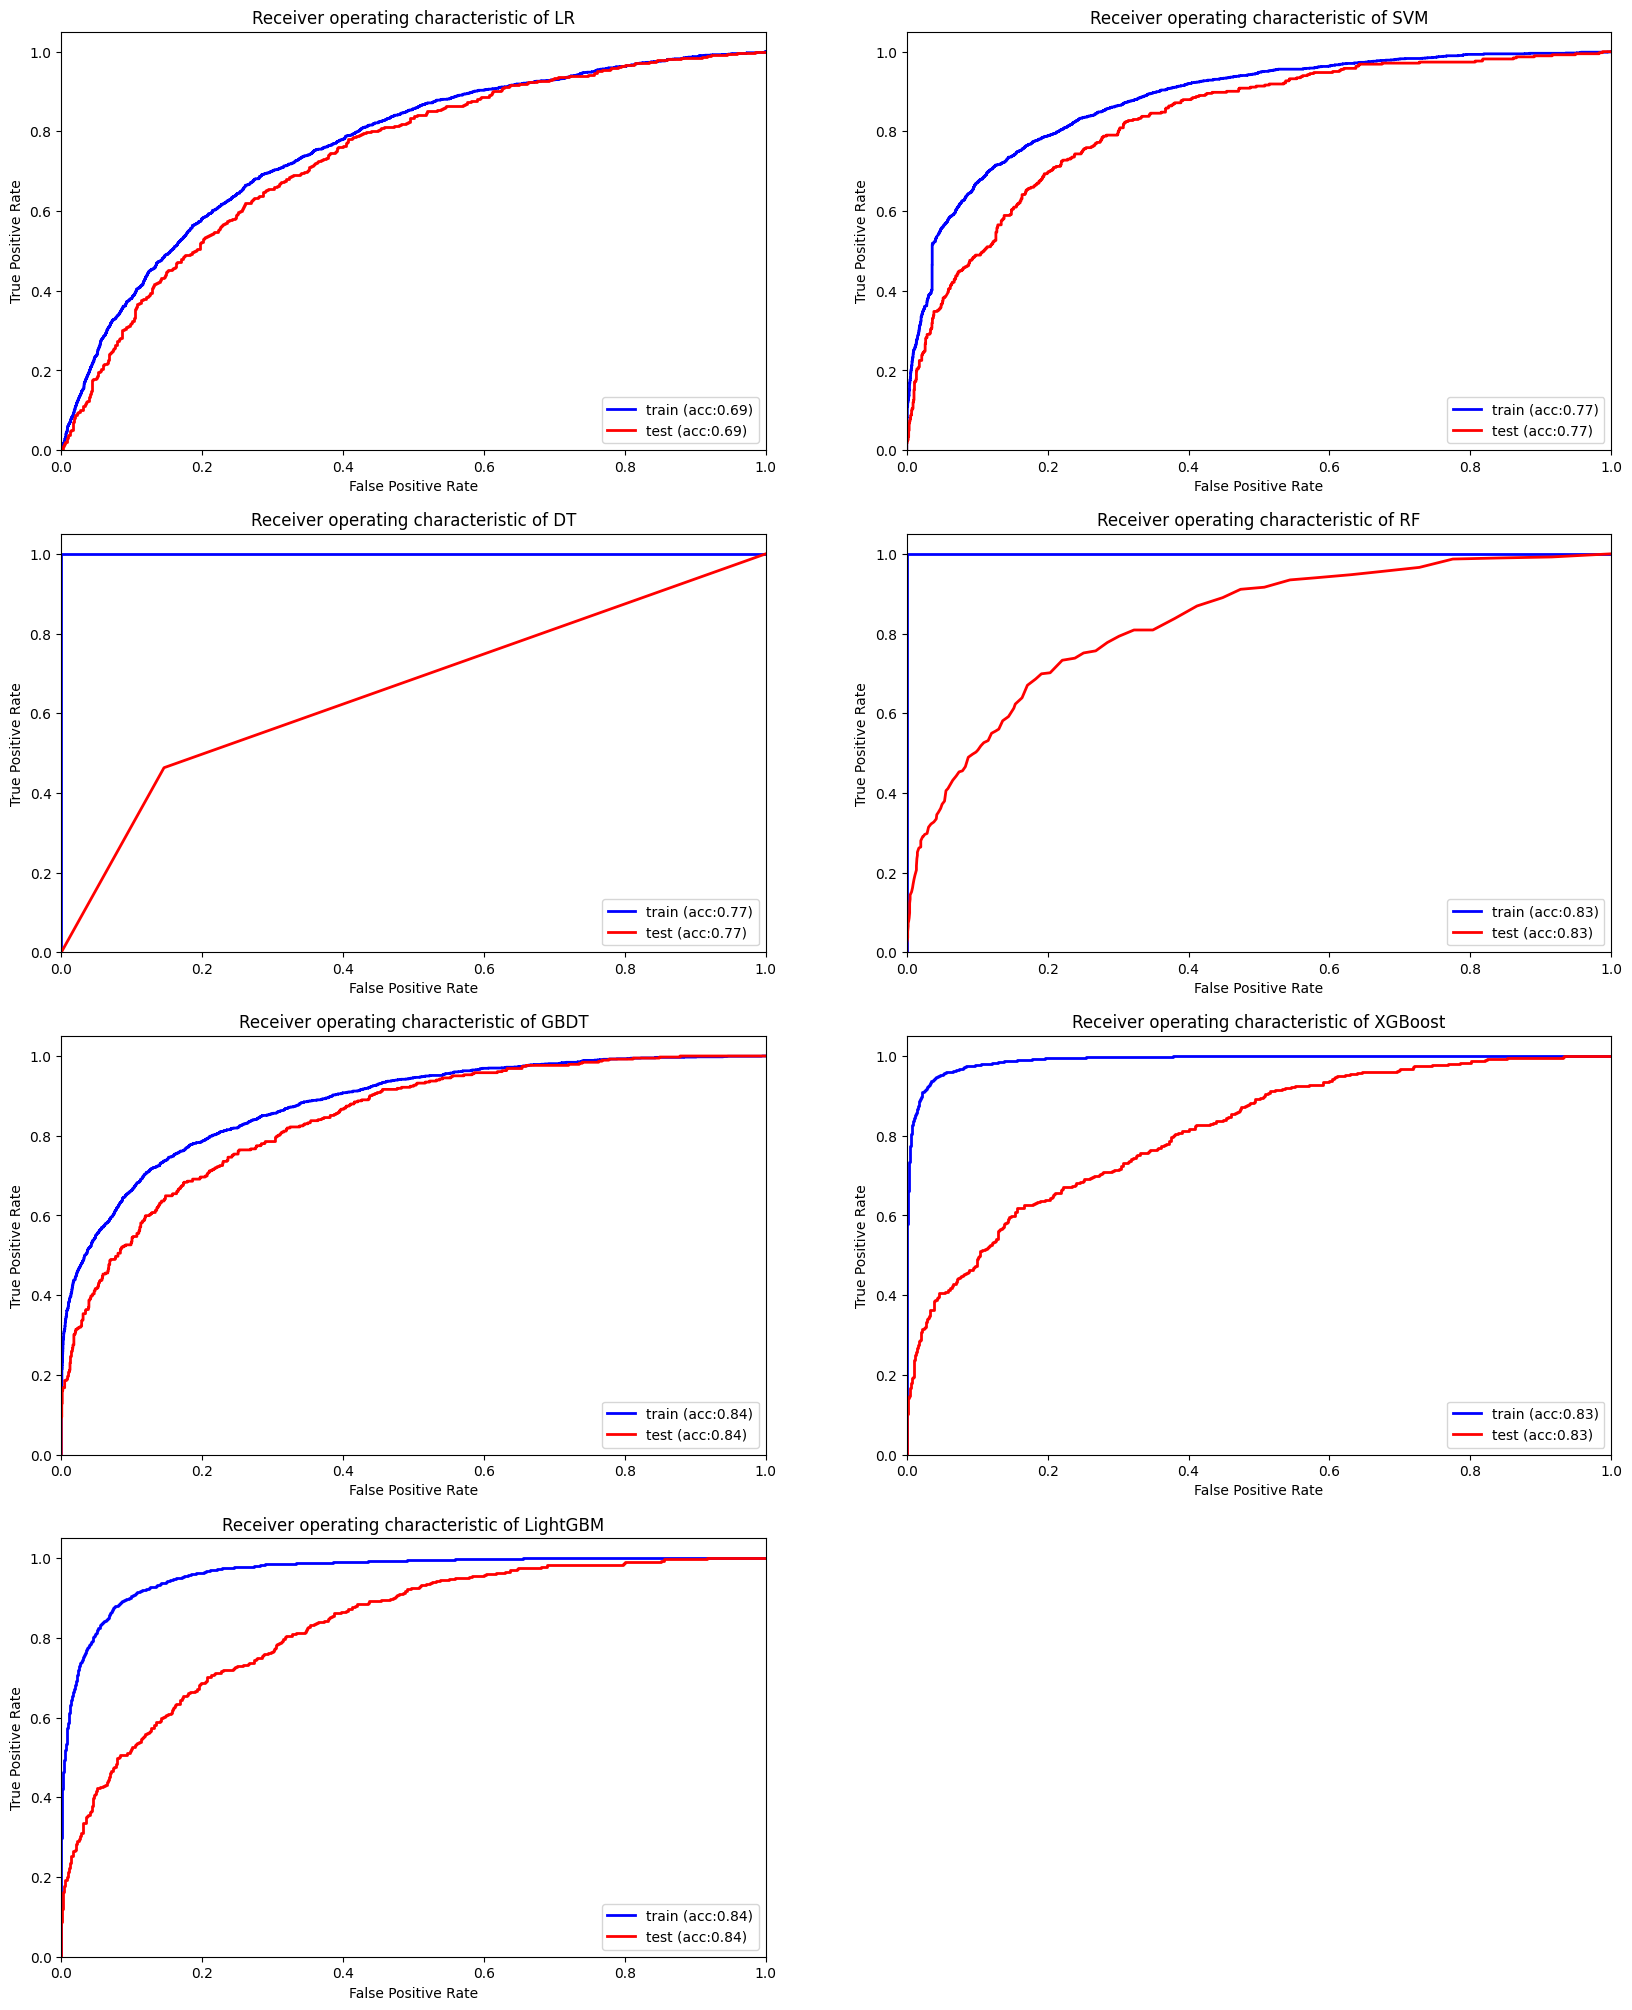

In [121]:
df_result = pd.DataFrame(columns=('Model', 'dataset', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC'))
row = 0
fprs_train = []
tprs_train = []
aucs_train = []
fprs_test = []
tprs_test = []
aucs_test = []
i = 0
plt.figure(figsize=(20,25))
for name, clf in models.items():
    
    clf.fit(X_train, y_train)
    acc, p, r, f1, fpr_train, tpr_train, auc_train = get_metric(clf, X_train, y_train)
    fprs_train.append(fpr_train)
    tprs_train.append(tpr_train)
    aucs_train.append(auc_train)
    df_result.loc[row] = [name, 'train', acc, p, r, f1, auc_train]
    row += 1

    acc, p, r, f1, fpr_test, tpr_test, auc_test = get_metric(clf, X_test, y_test)
    fprs_test.append(fpr_test)
    tprs_test.append(tpr_test)
    aucs_test.append(auc_test)
    df_result.loc[row] = [name, 'test', acc, p, r, f1, auc_test]
    row += 1

#     plt.figure()
    plt.subplot(4,2,i+1)
    lw = 2
    plt.plot(fpr_train, tpr_train, color='b', lw=lw, label='train (acc:%0.2f)' % acc)     # 这里进行指标的选取
    plt.plot(fpr_test, tpr_test, color='r', lw=lw, label='test (acc:%0.2f)' % acc)
#     plt.plot([0, 1], [0, 1], color='y', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of '+name)
    plt.legend(loc="lower right")
    plt.savefig(name + '.jpg')
    i+=1
plt.show()

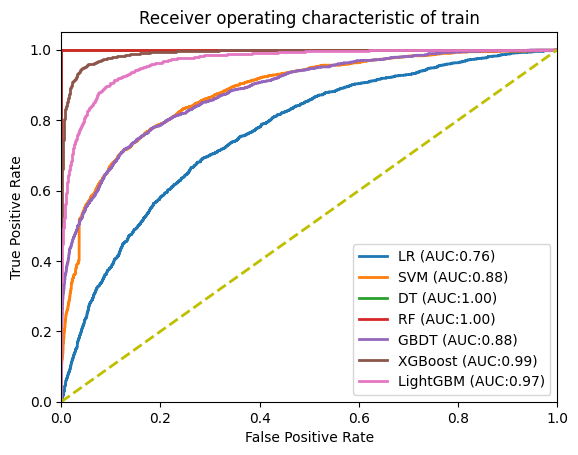

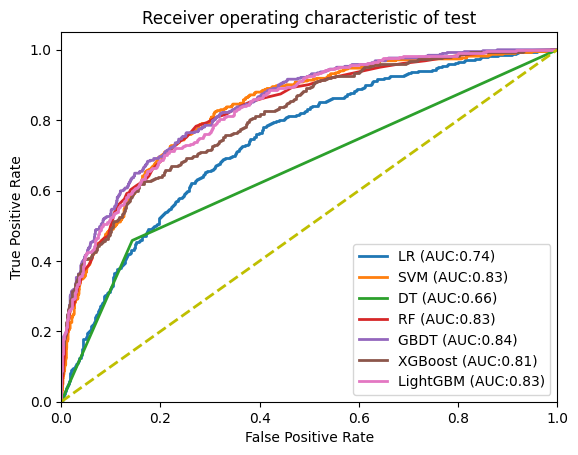

In [104]:
def plot_roc(fprs, tprs, aucs, title):
    plt.figure()
    lw = 2
    colors = ['cornflowerblue', 'r', 'darkorange', 'b', '']
    for i, name in enumerate(models):
        plt.plot(fprs[i], tprs[i], lw=lw,
                 label='{0} (AUC:{1:0.2f})'.format(name, aucs[i]))
    plt.plot([0, 1], [0, 1], color='y', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of '+title)
    plt.legend(loc="lower right")
#     plt.savefig(title + '.jpg')
    plt.show()

plot_roc(fprs_train, tprs_train, aucs_train, 'train')
plot_roc(fprs_test, tprs_test, aucs_test, 'test')

In [105]:
from sklearn.model_selection import StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=3)

# 使用的是随机森林算法

In [106]:
rf_model = LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=1000)
rf_model = SVC(class_weight='balanced', gamma='auto', probability=True)
rf_model = DecisionTreeClassifier(class_weight='balanced')
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=1000)
# rf_model = GradientBoostingClassifier(n_estimators=100)
# rf_model = XGBClassifier(n_estimators=100)
# rf_model = lgb.LGBMClassifier(n_estimators=100)


In [107]:
rf_model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=1000)

In [108]:
y_pre = rf_model.predict(X_test)

# 混淆矩阵

In [109]:
# -*-coding:utf-8-*-
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pre)

array([[1388,   66],
       [ 242,  140]], dtype=int64)

# 进行预测

In [110]:
data = pd.read_csv('./data/long-customer-test.csv')
data

,CustomerId,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15647311,608,1,41,1,83807.86,1,0,1,112542.58
1,15737452,653,0,58,1,132602.88,1,1,0,5097.67
2,15577657,732,0,41,8,0.00,2,1,1,170886.17
3,15589475,591,1,39,3,0.00,3,1,0,140469.38
4,15687946,556,1,61,2,117419.35,1,1,1,94153.83
...,...,...,...,...,...,...,...,...,...,...
995,15732202,615,0,34,1,83503.11,2,1,1,73124.53
996,15735078,724,1,53,1,139687.66,2,1,1,12913.92
997,15707861,520,1,46,10,85216.61,1,1,0,117369.52
998,15594612,702,0,44,9,0.00,1,0,0,59207.41


In [111]:
def age_con(x):
    if (0<=x)&(x<=3):
        return '新客户'
    elif (3<x)&(x<=6):
        return '稳定客户'
    else:
        return '老客户'
data['Status'] = data['Tenure'].apply(lambda x:age_con(x))

In [112]:
def bla_con(x):
    if (0<=x)&(x<=50000):
        return '低资产'
    elif (50000<x)&(x<=90000):
        return '中下资产'
    elif (90000<x)&(x<=120000):
        return '中上资产'
    else:
        return '高资产'
data['AssetStage'] = data['Balance'].apply(lambda x:bla_con(x))

In [113]:
def Status_con(x):
    if x=='新客户0':
        return 0
    elif x=='稳定客户0':
        return 1
    elif x=='老客户0':
        return 2
    elif x=='新客户1':
        return 3
    elif x=='稳定客户1':
        return 4
    elif x=='老客户1':
        return 5
data['IsActiveStatus'] = (data['Status']+data['IsActiveMember'].astype('str')).apply(lambda x:Status_con(x))

In [114]:
def Balance_con(x):
    if x=='低资产0':
        return 0
    elif x=='中下资产0':
        return 1
    elif x=='中上资产0':
        return 2
    elif x=='高资产0':
        return 3
    elif x=='低资产1':
        return 6
    elif x=='中下资产1':
        return 7
    elif x=='中上资产1':
        return 8
    elif x=='高资产1':
        return 9
data['IsActiveAssetStage'] = (data['AssetStage']+data['IsActiveMember'].astype('str')).apply(lambda x:Balance_con(x))

In [115]:
def HasCrCard_con(x):
    if x=='低资产0':
        return 0
    elif x=='中下资产0':
        return 2
    elif x=='中上资产0':
        return 5
    elif x=='高资产0':
        return 5
    elif x=='低资产1':
        return 6
    elif x=='中下资产1':
        return 7
    elif x=='中上资产1':
        return 9
    elif x=='高资产1':
        return 9
data['CrCardAssetStage'] = (data['AssetStage']+data['HasCrCard'].astype('str')).apply(lambda x:HasCrCard_con(x))

In [116]:
for i in ['Status','AssetStage']:
    lb = LabelEncoder()
    data[i] = lb.fit_transform(data[i])
feat = [i for i in data.columns.tolist() if i!='CustomerId']
test = scaler.fit_transform(data[feat])
# X_test = scaler.fit_transform(X_test)

In [125]:
data['Exited'] = rf_model.predict(test)

In [126]:
lis = ['15579131','15674442','15719508','15730076','15792228']
for i in lis:
    r = data[data['CustomerId']==int(i)]['Exited'].values
    print(str(i)+':'+str(r))

15579131:[0]
15674442:[0]
15719508:[1]
15730076:[0]
15792228:[1]


In [131]:
data[['CustomerId','Exited']].to_excel("./res/result5.xlsx",encoding='utf-8',index=False)